In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import randrange
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
import sys
import time
from time import time

#### The K-inator; A Notebook For Threat Hunting Using k-means
Part of the DUNE project (https://github.com/opendr-io/dune) and useful for hunting threats that are resistant to conventional detection. This notebook does k-means anomaly detection using fields of your choice. The examples below are for analysis of CloudTrail logs, refactor as needed. Use the accompanying notebook to compute the best value of k for your dataset first. The output anomalous events can be queried, sifted, aggregated, and sorted using the tools at the end.

In [3]:
# kmeans_input file - or you can ingest directly from S3 using the boto3 module'
# if you do that at great scale, you might run the notebook in the same region
# as the bucket to avoid egress charges
kmeans_file = 'cloudtrail.csv'

In [4]:
# Read the file and extract relevant fields
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 30)
#kmeans_input = pd.read_csv(kmeans_file, encoding='utf-8', low_memory=True)  # Adjust the encoding if needed
kmeans_input = pd.read_csv(kmeans_file, encoding='utf-8', low_memory=False)  # Adjust the encoding if needed
print('kmeans_input data shape:')
print(type(kmeans_input)); print(kmeans_input.shape); print(len(kmeans_input.columns))


kmeans_input data shape:
<class 'pandas.core.frame.DataFrame'>
(25675, 9)
9


In [5]:
cardinality = (
    kmeans_input.nunique(dropna=True)
      .sort_values(ascending=False)
)
print('Choose your fields:')
print(cardinality)

Choose your fields:
eventid             25675
timestamp           17394
                    ...  
userIdentity.arn        3
tactic2                 3
Length: 9, dtype: int64


In [6]:
kmeans_fields_to_encode = [ 'sourceIPAddress', 'eventSource', 'eventName', 'userAgent', 'userIdentity.arn'] 

In [7]:
# Select the columns you want to use for outlier detection
kmeans_columns_for_outliers = [ 'sourceIPAddress', 'eventSource', 'eventName', 'userAgent', 'userIdentity.arn'] 

In [8]:
kmeans_input.dtypes

eventid       int64
timestamp    object
              ...  
tactic1      object
tactic2      object
Length: 9, dtype: object

In [9]:
# sum uniuque field values, can inform pre-processing decisions
sum_n_unique = 0
for field in kmeans_fields_to_encode:
    print(field)
    print(kmeans_input[field].nunique())
    sum_n_unique += kmeans_input[field].nunique()
    print(kmeans_input[field].value_counts())
    print("==============")

sourceIPAddress
47
sourceIPAddress
vpc-flow-logs.amazonaws.com    21730
198.18.161.170                  3028
                               ...  
10.1.179.219                       1
10.0.185.198                       1
Name: count, Length: 47, dtype: int64
eventSource
19
eventSource
sts.amazonaws.com     21749
ec2.amazonaws.com      3322
                      ...  
ds.amazonaws.com          4
logs.amazonaws.com        4
Name: count, Length: 19, dtype: int64
eventName
75
eventName
AssumeRole                 21730
DescribeVolumes              593
                           ...  
ModifySnapshotAttribute        1
StopInstances                  1
Name: count, Length: 75, dtype: int64
userAgent
28
userAgent
vpc-flow-logs.amazonaws.com                                                                                                              21730
console.ec2.amazonaws.com                                                                                                                 3161
  

In [10]:
print(sum_n_unique)

172


In [11]:
# print statistical summary, useful in assesing balance 
for field in kmeans_fields_to_encode:
    print(field)
    print(kmeans_input[field].value_counts().describe())
    print("==============")

sourceIPAddress
count       47.000000
mean       546.276596
             ...     
75%         36.000000
max      21730.000000
Name: count, Length: 8, dtype: float64
eventSource
count       19.000000
mean      1351.315789
             ...     
75%         44.000000
max      21749.000000
Name: count, Length: 8, dtype: float64
eventName
count       75.000000
mean       342.333333
             ...     
75%         39.000000
max      21730.000000
Name: count, Length: 8, dtype: float64
userAgent
count       28.000000
mean       916.964286
             ...     
75%         10.750000
max      21730.000000
Name: count, Length: 8, dtype: float64
userIdentity.arn
count        3.000000
mean      8558.333333
             ...     
75%      12835.500000
max      21730.000000
Name: count, Length: 8, dtype: float64


In [12]:
#convert to categorical type and then to integers 
for field in kmeans_fields_to_encode:
    kmeans_input[field] = kmeans_input[field].astype('category')
    kmeans_input[field] = kmeans_input[field].cat.codes

In [13]:
print(kmeans_input.columns)

Index(['eventid', 'timestamp', 'sourceIPAddress', 'eventSource', 'eventName',
       'userAgent', 'userIdentity.arn', 'tactic1', 'tactic2'],
      dtype='object')


#### Apply PCA for dimensionality reduction


In [15]:
#remove the mean and scale each feature/variable to unit variance
KX = kmeans_input.loc[:, kmeans_columns_for_outliers].values
# Standardizing the features
KX = StandardScaler().fit_transform(KX)

In [16]:
print(np.asarray(KX).shape, np.asarray(KX).dtype)


(25675, 5) float64


In [17]:
kmeans_pca_2 = PCA(n_components=2)
KX2 = kmeans_pca_2.fit_transform(KX)
#reduce dimensionality of the data so we can plot it
print(KX2.shape)
print(np.asarray(KX).shape, np.asarray(KX).dtype)

(25675, 2)
(25675, 5) float64


In [18]:
from time import perf_counter
from sklearn.decomposition import PCA

print("before PCA", KX.shape, KX.dtype, flush=True)

t0 = perf_counter()
pca_5 = PCA(n_components=5)
KX = pca_5.fit_transform(KX)
print("after PCA", KX.shape, "secs:", perf_counter() - t0, flush=True)


before PCA (25675, 5) float64
after PCA (25675, 5) secs: 0.002875599999242695


In [19]:
# variable to represent a fraction of the data considered to be outliers 
kmeans_num_samples = kmeans_input.shape[0]
kmeans_out_frac=0.01

In [20]:
kmeans_fraction_of_inliers = (1. - kmeans_out_frac) 
# (1 - fraction of outliers)
kmeans_num_inliers = int(kmeans_fraction_of_inliers * kmeans_num_samples)
# fraction of inliers * total number of samples
kmeans_num_outliers = int(kmeans_out_frac * kmeans_num_samples) 
# fraction of outliers * total number of samples

In [21]:
print('No. of inliers: %i' % kmeans_num_inliers)
print('No. of outliers: %i' % kmeans_num_outliers)

No. of inliers: 25418
No. of outliers: 256


In [22]:
random_state_number = 42
rs = np.random.RandomState(random_state_number)  
# random state - force the centroids to begin 
# in the same locations bc we are going to compare 
# different clusters 
print(type(KX2))

<class 'numpy.ndarray'>


In [23]:
K=28

In [24]:
#begin = time()
kmeans = KMeans(n_clusters = K).fit(KX2)
print(kmeans)
# init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42
# generate five clusters

KMeans(n_clusters=28)


In [25]:
center = kmeans.cluster_centers_
print(center)
# output the centroids

[[ -0.87150862  -0.03375794]
 [  4.78428698   0.45377849]
 [ 10.09557691 -12.08656186]
 [  8.83222898  -4.0087696 ]
 [  3.75389549  -0.63279559]
 [  5.28137593   0.5733079 ]
 [  5.95265867  -8.86684314]
 [  4.00377767   0.18628734]
 [  6.42516608  -3.12951167]
 [  4.48030851   0.95502987]
 [  3.28449402   0.3684638 ]
 [  8.32276137 -12.49184424]
 [  6.24792019   1.25470893]
 [  4.53483023   0.35722377]
 [  9.37955392  -9.2754125 ]
 [  3.91548151   0.78655006]
 [  5.16442798   1.12548008]
 [  4.99495904   0.50091239]
 [  5.1558806   -6.93013743]
 [  4.65611638   0.4291474 ]
 [  6.73328037  -4.14865715]
 [  3.3519528    0.01859633]
 [  6.59125911  -1.63732958]
 [  4.29432525   0.33887323]
 [  7.01901808 -11.58240679]
 [  5.51065899  -0.07115297]
 [  4.11508655   0.2782525 ]
 [  3.75843086   0.14345815]]


In [26]:
PERCENTILE=99.0

In [27]:
# Predict the closest cluster for each data point
closest_cluster = kmeans.predict(KX2)
kmeans_input['cluster'] = kmeans.predict(KX2)

# Calculate the distance of each data point to its closest cluster center
distances = pairwise_distances_argmin_min(KX2, kmeans.cluster_centers_)[1]

# Define a threshold to identify anomalies
threshold = np.percentile(distances, PERCENTILE)

# Find the indices of the anomalies
kmeans_anomaly_indices = np.where(distances > threshold)[0]

# Print the indices of the anomalies
print("Anomaly indices:", kmeans_anomaly_indices)
print(len(kmeans_anomaly_indices))

Anomaly indices: [21740 21741 21742 21743 21744 21745 21747 21748 21749 21750 21751 21752
 21753 21754 21755 21756 21757 21758 21759 21760 21761 21762 21763 21766
 21767 21768 21769 21774 21775 21776 21777 21778 21779 21780 21781 21782
 22126 22127 22128 22129 22130 22131 22132 22133 22134 22135 22136 22137
 22138 22139 22140 22141 22142 22143 22144 22145 22146 22147 22148 22149
 22150 22151 22152 22153 22154 22161 22162 22166 22172 22182 22183 22189
 22202 22203 22206 22207 22216 22220 22221 22227 22324 22329 22330 22331
 22333 22336 22342 22343 22344 22345 22346 22347 22348 22349 22549 22553
 22883 22907 22931 23072 23234 23360 23527 23545 23580 23592 23593 23594
 23595 23599 23609 23618 23619 23620 23621 23622 23636 23650 23651 23652
 23653 23654 23655 23667 23668 23669 23670 23785 23786 23787 23788 23789
 23790 23791 23792 23793 23804 23805 23807 23808 23825 23826 23841 23842
 23843 23844 23846 23856 23857 23859 23860 23861 23862 23863 23864 23877
 23879 23881 23882 23998 23999 240

In [28]:
# initialize two new rows in the dataframe
kmeans_input['outlier_kmeans'] = 0
kmeans_input['cluster'] = -1
# cc - set the value of the cluster column for each row
for index in range(kmeans_input.shape[0]):
    kmeans_input.at[index, 'cluster'] = closest_cluster[index]
# make it string to plot
    if index in kmeans_anomaly_indices:
         kmeans_input.at[index, 'outlier_kmeans'] = str(1) 

C:\Users\flynn\AppData\Local\Temp\ipykernel_11476\3342058334.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  kmeans_input.at[index, 'outlier_kmeans'] = str(1)


In [30]:
#create two new columns, c1 and c2, and populate them with values from a 2D array
kmeans_input[['c1', 'c2']] = KX[:, :2]

In [ ]:
print(len(kmeans_input.query('outlier_kmeans == "1"')))
#count the number of outliers

In [32]:
print(closest_cluster)

[ 0  0  0 ... 12 12 12]


In [33]:
kmeans_input.columns

Index(['eventid', 'timestamp', 'sourceIPAddress', 'eventSource', 'eventName',
       'userAgent', 'userIdentity.arn', 'tactic1', 'tactic2', 'cluster',
       'outlier_kmeans', 'c1', 'c2'],
      dtype='object')

In [34]:
print(KX2)

[[-0.87150862 -0.03375794]
 [-0.87150862 -0.03375794]
 [-0.87150862 -0.03375794]
 ...
 [ 6.47417484  0.84598877]
 [ 6.47417484  0.84598877]
 [ 6.30567573  1.36537967]]


In [35]:
print(len(KX2))

25675


In [36]:
print(kmeans_input.shape)

(25675, 13)


In [37]:
# create new series by selecting values from the columns at the positions 
# specified in kmeans_anomaly_indices. This series will contain the c1 values of the 
# data points that are considered anomalies.
x_anom = kmeans_input['c1'][kmeans_anomaly_indices]
y_anom = kmeans_input['c2'][kmeans_anomaly_indices]

In [38]:
# new version of the above cell - maybe unncesessay 

idx = np.asarray(kmeans_anomaly_indices).ravel()

assert idx.ndim == 1
assert idx.max() < len(kmeans_input)

x_anom = kmeans_input['c1'].to_numpy()[idx]
y_anom = kmeans_input['c2'].to_numpy()[idx]


In [39]:
sns.set(rc={"figure.figsize":(15, 10)}) #width=15, #height=10

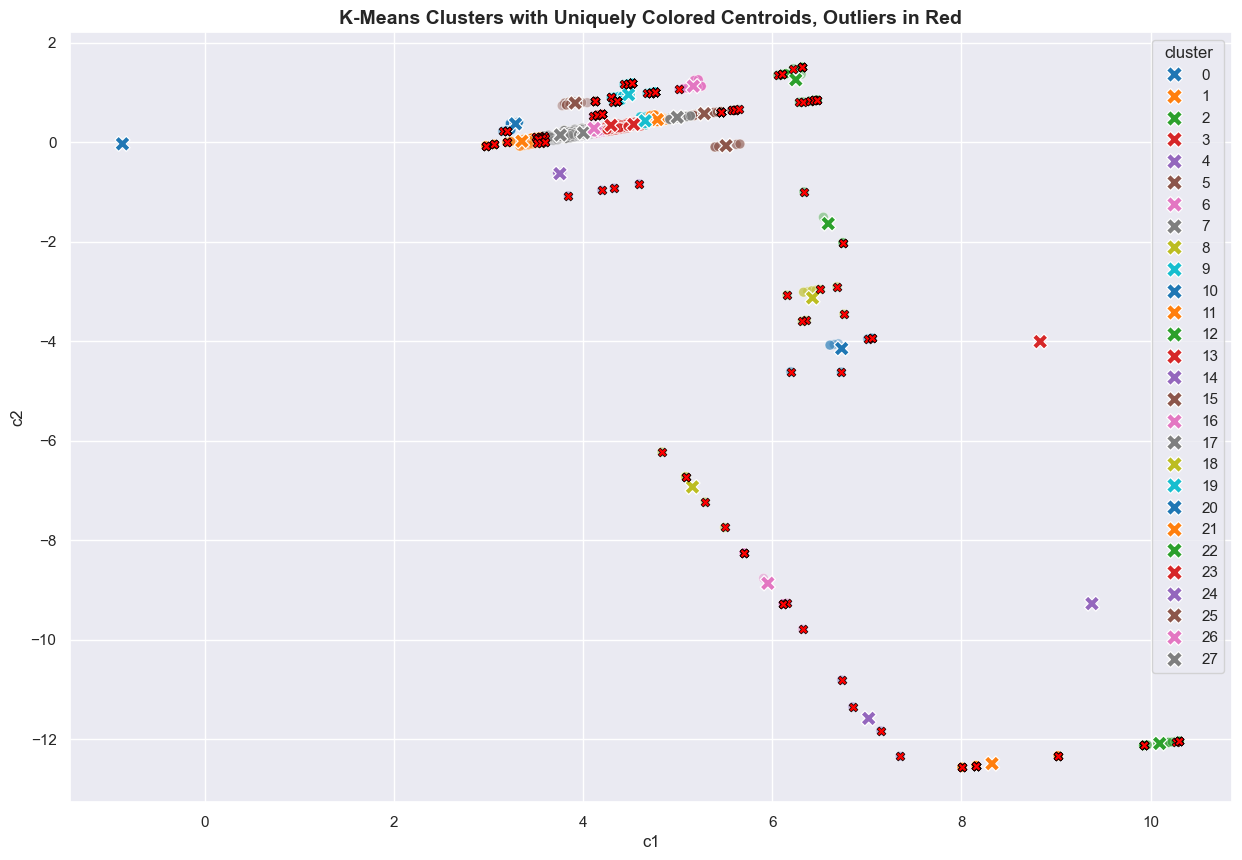

In [40]:
# pd.plotting.parallel_coordinates(KX2, 'cluster')
# KX -- cluster center
# s (square) = outlier
# use Seaborn's scatterplot function to plot the c1 and c2 columns
# from DataFrame kmeans_input. The hue parameter is set to kmeans.labels_, 
# which are the labels assigned by a k-means clustering algorithm, 
# thereby coloring each point according to its cluster label.

ax = sns.scatterplot(
    x=kmeans_input['c1'],
    y=kmeans_input['c2'],
    hue=kmeans.labels_,
    palette='tab10',     # or tab20 if K > 10
    alpha=0.4,
    s=50,
    legend=False        # important: avoid legend overload
)

# plot the centers of the clusters. The centers are accessed via kmeans.cluster_centers_,
# and hue=range(K) assigns a unique color to each center. The centers are plotted 
# with a larger size (s=80) and a different marker style (marker='KX')
centers_df = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=['c1', 'c2']
)
centers_df['cluster'] = centers_df.index.astype(str)

sns.scatterplot(
    data=centers_df,
    x='c1',
    y='c2',
    hue='cluster',
    palette='tab10',   # or 'tab20' if K > 10
    marker='X',
    s=120,
    legend='full',
    ax=ax
)
# Anomalies are plotted with distinctive styling to make them stand out: 
# red color, square markers (marker='s'), larger size (s=40), and 
# a black edge (edgecolor='black').
sns.scatterplot(
    x=x_anom,
    y=y_anom,
    color="red",
    s=40,
    marker="X",
    edgecolor="black",
    legend=False,
    ax=ax
)
ax.set_title(
    "K-Means Clusters with Uniquely Colored Centroids, Outliers in Red",
    fontsize=14,
    fontweight="bold"
);

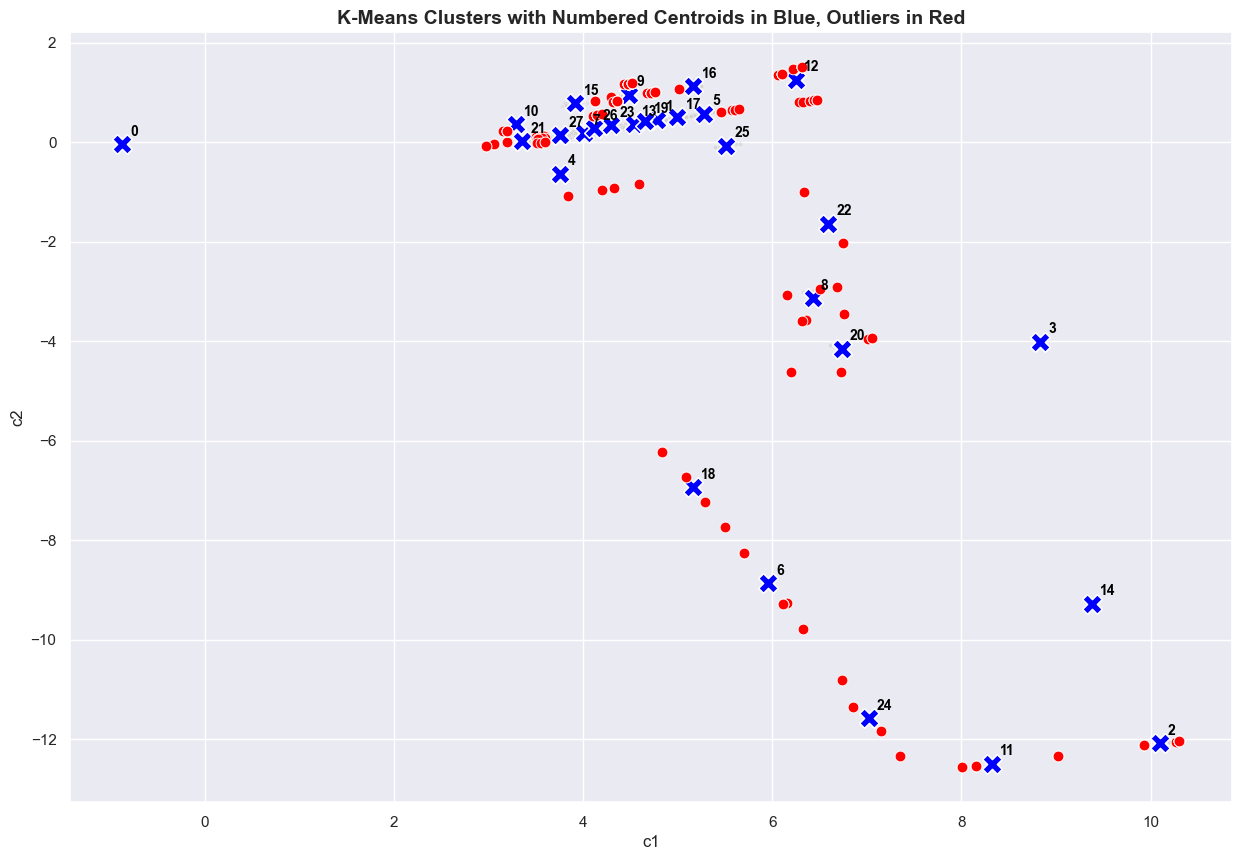

In [41]:
# alternative plot with numbered centers - may be more readable
# than a conventional legend with a lot of centers

ax = sns.scatterplot(
    x=kmeans_input['c1'],
    y=kmeans_input['c2'],
    color="lightgray",
    alpha=0.4,
    s=10
)
# Plot cluster centers
sns.scatterplot(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    color="blue",
    marker="X",
    s=200,
    ax=ax
)
sns.scatterplot(
    x=kmeans_input.loc[idx, 'c1'],
    y=kmeans_input.loc[idx, 'c2'],
    color="red",
    s=60,
    ax=ax
)
# Number the centers
for i, (cx, cy) in enumerate(kmeans.cluster_centers_):
    ax.annotate(
        str(i),
        (cx, cy),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        color="black"
    )
ax.set_title(
    "K-Means Clusters with Numbered Centroids in Blue, Outliers in Red",
    fontsize=14,
    fontweight="bold"
)
plt.show()

In [42]:
# Normalize outlier_kmeans: force numeric 0/1, anything else -> NaN
kmeans_input['outlier_kmeans'] = pd.to_numeric(kmeans_input['outlier_kmeans'], errors='coerce')

print("dtype after numeric coercion:", kmeans_input['outlier_kmeans'].dtype)
print(kmeans_input['outlier_kmeans'].value_counts(dropna=False))

dtype after numeric coercion: int64
outlier_kmeans
0    25418
1      257
Name: count, dtype: int64


In [43]:
# scored anomalies in the encoded dataframe
# scored rows (encoded kmeans_input)
kmeans_anomalies_scored = kmeans_input[kmeans_input['outlier_kmeans'] == 1][['eventid', 'outlier_kmeans'] ].copy()

# list of GUIDs that were flagged
kmeans_anomalous_eventids = kmeans_anomalies_scored['eventid'].unique()

# pull original CloudTrail rows based on GUIDs
raw_kmeans = pd.read_csv(kmeans_file, encoding='utf-8', low_memory=False)  # Adjust the encoding if needed
kmeans_output = raw_kmeans[raw_kmeans['eventid'].isin(kmeans_anomalous_eventids)].copy()

# optional: keep rank and votes attached by merging back on eventid
kmeans_output = kmeans_output.merge(
    kmeans_input[['eventid', 'outlier_kmeans']],
    on='eventid',
    how='left',
    suffixes=('', '_score')
)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None)
kmeans_output

,eventid,timestamp,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,tactic1,tactic2,outlier_kmeans
0,22741,2018-09-26T18:09:00.000Z,198.18.161.170,billingconsole.amazonaws.com,AWSPaymentInstrumentGateway.Delete,Null,arn:aws:iam::123456789012:alex,Defense Evasion,-,1
1,22742,2018-09-28T13:39:07.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4311831040),arn:aws:iam::123456789012:alex,Persistence,Initial Access,1
...,...,...,...,...,...,...,...,...,...,...
255,26674,2018-12-18T21:47:24.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:alex,Execution,-,1
256,26675,2018-12-18T21:45:59.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:alex,Execution,-,1


In [44]:
# check that the event IDs match between the raw_kmeans and scored data rows
kmeans_ts_check = (
    raw_kmeans[['eventid', 'timestamp']]
    .merge(
        kmeans_output[['eventid', 'timestamp']],
        on='eventid',
        how='inner',
        suffixes=('_raw_kmeans', '_kmeans_output')
    )
)

# compare timestamps
kmeans_ts_check['timestamp_match'] = (
    kmeans_ts_check['timestamp_raw_kmeans'] == kmeans_ts_check['timestamp_kmeans_output']
)

# count matches
kmeans_tmatch_counts = kmeans_ts_check['timestamp_match'].value_counts()

num_correct = kmeans_tmatch_counts.get(True, 0)
num_incorrect = kmeans_tmatch_counts.get(False, 0)

print(f"Timestamp matches   : {num_correct}")
print(f"Timestamp mismatches: {num_incorrect}")
print(f"Total compared      : {num_correct + num_incorrect}")

# sanity check (optional)
if num_incorrect > 0:
    print("WARNING: There are mismatched timestamps")

# we are done with raw_kmeans — free memory
#del raw_kmeans
#print('deleted the raw_kmeans dataframe to free memory.')


Timestamp matches   : 257
Timestamp mismatches: 0
Total compared      : 257


In [45]:
from threadpoolctl import threadpool_info
threadpool_info()


[{'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 4,
  'prefix': 'libscipy_openblas',
  'filepath': 'D:\\testing\\dune\\Lib\\site-packages\\numpy.libs\\libscipy_openblas64_-9e3e5a4229c1ca39f10dc82bba9e2b2b.dll',
  'version': '0.3.30',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX'},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 4,
  'prefix': 'libscipy_openblas',
  'filepath': 'D:\\testing\\dune\\Lib\\site-packages\\scipy.libs\\libscipy_openblas-48c358d105077551cc9cc3ba79387ed5.dll',
  'version': '0.3.29.dev',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX'},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'num_threads': 4,
  'prefix': 'vcomp',
  'filepath': 'D:\\testing\\dune\\Lib\\site-packages\\sklearn\\.libs\\vcomp140.dll',
  'version': None}]

In [46]:
import os
print(os.path.getsize("Kmeans-head.ipynb") / (1024*1024), "MB")


0.21912288665771484 MB
